<a href="https://colab.research.google.com/github/stalhabukhari/JAX-DNN-MNIST/blob/main/JAX_DNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST DNN in JAX

In this notebook:
- A fully-connected network is implemented in `jax`.
- `tensorflow_datasets` is used for a nifty data pipeline.

This notebook is for instructional purposes only.

### Installation

In [ ]:
!nvcc --version
# Install the latest JAXlib version.
# !pip install --upgrade -q pip jax jaxlib
!pip install --upgrade jax jaxlib==0.1.67+cuda110 -f https://storage.googleapis.com/jax-releases/jax_releases.html

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
     |████████████████████████████████| 675kB 7.6MB/s 
     |████████████████████████████████| 172.6MB 86kB/s 
  Created wheel for jax: filename=jax-0.2.14-cp37-none-any.whl size=771355 sha256=49413fc6c5cd2d5cce97f45d8c57fbacfbd4138f245ce4cc7a57aee7d726f69f
  Stored in directory: /root/.cache/pip/wheels/3a/ca/91/9e1f07c9a49b16e0a22112e77e579d5a987009459f130d998b
Successfully built jax
  Found existing installation: jax 0.2.13
    Uninstalling jax-0.2.13:
      Successfully uninstalled jax-0.2.13
  Found existing installation: jaxlib 0.1.66+cuda110
    Uninstalling jaxlib-0.1.66+cuda110:
      Successfully uninstalled jaxlib-0.1.66+cuda110


### Imports

In [ ]:
import time, itertools
from functools import partial
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

import jax
import jax.numpy as jnp
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax

from jax.lib import xla_bridge
assert xla_bridge.get_backend().platform=='gpu' and jax.local_device_count()
jax.__version__

'0.2.14'

### Configurations

In [ ]:
num_classes = 10
reshape_args = [(-1, 28*28), (-1,)]
input_shape = reshape_args[0]

step_size = 0.001
num_epochs = 10
batch_size = 128
momentum_mass = 0.9
rng = random.PRNGKey(0)

### Dataset (via `tensorflow_datasets`)

In [ ]:
# Training Data
ds_train = tfds.load('mnist', split='train', shuffle_files=True)
total_train_imgs = len(ds_train)
print(f'Training Set Images: {total_train_imgs}')
ds_train = ds_train.shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
ds_train = tfds.as_numpy(ds_train)

# Testing Data
ds_test = tfds.load('mnist', split='test', shuffle_files=False)
total_test_imgs = len(ds_test)
print(f'Testing Set Images: {total_test_imgs}')
ds_test = ds_test.shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = tfds.as_numpy(ds_test)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Training Set Images: 60000
Testing Set Images: 10000


### NN Architecture (`jax.experimental.stax`)

In [ ]:
# {Dense(1024) -> ReLU}x2 -> Dense(10) -> LogSoftmax
init_random_params, predict = stax.serial(
    stax.Dense(1024), stax.Relu,
    stax.Dense(1024), stax.Relu,
    stax.Dense(10), stax.LogSoftmax)

### Utility functions

In [ ]:
# Utility functions in jax

def one_hot_nojit(x, k, dtype=jnp.float32):
    """ Create a one-hot encoding of x of size k. """
    return jnp.array(x[:, None] == jnp.arange(k), dtype)
one_hot = jit(partial(one_hot_nojit, k=num_classes, dtype=jnp.float32))

@jit
def loss(params, batch):
    """ Cross-entropy loss over a minibatch. """
    inputs, targets = batch
    return jnp.mean(jnp.sum( -targets*predict(params, inputs), axis=1))

@jit
def pred_check(params, batch):
    """ Correct predictions over a minibatch. """
    inputs, targets = batch
    predicted_class = jnp.argmax(predict(params, inputs), axis=1)
    return jnp.sum(predicted_class == targets)

@jit
def update(i, opt_state, batch):
    """ Single optimization step over a minibatch. """
    params = get_params(opt_state)
    return opt_update(i, grad(loss)(params, batch), opt_state)

In [ ]:
class MetricAccumulator(object):
    """ Class for collecting and plotting training/testing metrics. """

    def __init__(self, metric_list):
        metric_dict = {}
        for met in metric_list:
            metric_dict[met] = []

        self.metric_dict = metric_dict

    def update(self, metric_dict):
        for met in self.metric_dict.keys():
            self.metric_dict[met].append(metric_dict[met])

    def plot(self):
        fig, ax = plt.subplots()
        fig.suptitle('Per-epoch Metrics')

        for met in self.metric_dict.keys():
            y_axis = self.metric_dict[met]
            x_axis = np.arange(len(y_axis))
            ax.plot(x_axis, y_axis, linewidth=2, label=met)

        plt.xlabel('Epochs')
        plt.ylabel('Acc')
        ax.legend(fancybox=True)
        ax.grid()
        plt.show()

### Initialization

In [ ]:
# Initialize Network, Optimizer
opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)
_, init_params = init_random_params(rng, input_shape)
opt_state = opt_init(init_params)

# Counter
itercount = itertools.count()

### Training/Evaluation

In [ ]:
print("\nStarting training...\n")

MetAcc = MetricAccumulator(metric_list=['TrainAcc', 'TestAcc'])

for epoch in range(num_epochs):
    train_acc, test_acc = [], []

    # Training
    start_time = time.time()
    
    for batch_raw in ds_train:
        data = batch_raw["image"].reshape(*reshape_args[0])
        targets = one_hot(batch_raw["label"].reshape(*reshape_args[1]))
        opt_state = update(next(itercount), opt_state, (data, targets))
    
    epoch_time = time.time() - start_time
    print("\nEpoch {} in {:0.2f} sec".format(epoch+1, epoch_time))

    params = get_params(opt_state)

    # Train Acc
    correct_preds = 0.0
    for batch_raw in ds_train:
        data = batch_raw["image"].reshape(*reshape_args[0])
        targets = batch_raw["label"].reshape(*reshape_args[1])
        correct_preds += pred_check(params, (data, targets))
    train_acc.append(correct_preds/float(total_train_imgs))
    print(f"Training set accuracy: {train_acc}")
    
    # Test Acc
    correct_preds = 0.0
    for batch_raw in ds_test:
        data = batch_raw["image"].reshape(*reshape_args[0])
        targets = batch_raw["label"].reshape(*reshape_args[1])
        correct_preds += pred_check(params, (data, targets))
    test_acc.append(correct_preds/float(total_test_imgs))
    print(f"Test set accuracy: {test_acc}")

    MetAcc.update({'TrainAcc': train_acc, 'TestAcc': test_acc})


Starting training...


Epoch 1 in 8.51 sec
Training set accuracy: [DeviceArray(0.9573667, dtype=float32)]
Test set accuracy: [DeviceArray(0.9473, dtype=float32)]

Epoch 2 in 0.57 sec
Training set accuracy: [DeviceArray(0.9745, dtype=float32)]
Test set accuracy: [DeviceArray(0.9585, dtype=float32)]

Epoch 3 in 0.57 sec
Training set accuracy: [DeviceArray(0.9821, dtype=float32)]
Test set accuracy: [DeviceArray(0.96360004, dtype=float32)]

Epoch 4 in 0.58 sec
Training set accuracy: [DeviceArray(0.9863833, dtype=float32)]
Test set accuracy: [DeviceArray(0.96470004, dtype=float32)]

Epoch 5 in 0.59 sec
Training set accuracy: [DeviceArray(0.9914, dtype=float32)]
Test set accuracy: [DeviceArray(0.96660006, dtype=float32)]

Epoch 6 in 0.63 sec
Training set accuracy: [DeviceArray(0.99301666, dtype=float32)]
Test set accuracy: [DeviceArray(0.96620005, dtype=float32)]

Epoch 7 in 0.57 sec
Training set accuracy: [DeviceArray(0.99445003, dtype=float32)]
Test set accuracy: [DeviceArray(0.96760005, 

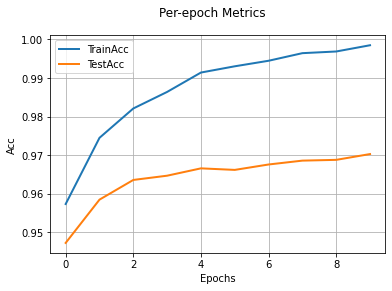

In [ ]:
MetAcc.plot()